In [1]:
# packages and modules used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display # used to display multiple tables in one cell beautifully

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.metrics import make_scorer, mean_squared_error
import sklearn.linear_model as linear_model

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = pd.concat([train, test])

# Data Pre-Processing & Visualization

In [3]:
# check if data loaded correctly
display(train)
train.describe()['SalePrice'] # basic info of SalePrice
# train_data.info() # more technical information of trainning data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

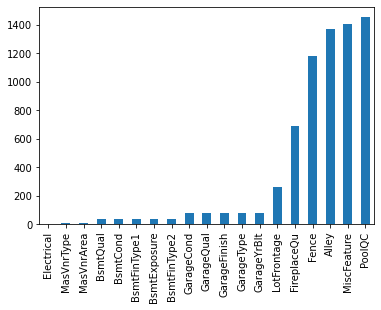

In [4]:
# replace the numeric missing values with their respective column means
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
# visualize the columns have most missing values
missing.plot(kind='bar'); 

# couple of ways to replace the categorical values:
#   1. one-hot encoding use get_dummies() from pandas
#   2. manually assigning values
#   3. encoding with integer values based on their realationship with SalePrice.

In [5]:
categorical_features = train.select_dtypes(include='object').columns
numerical_features = train.select_dtypes(exclude='object').columns

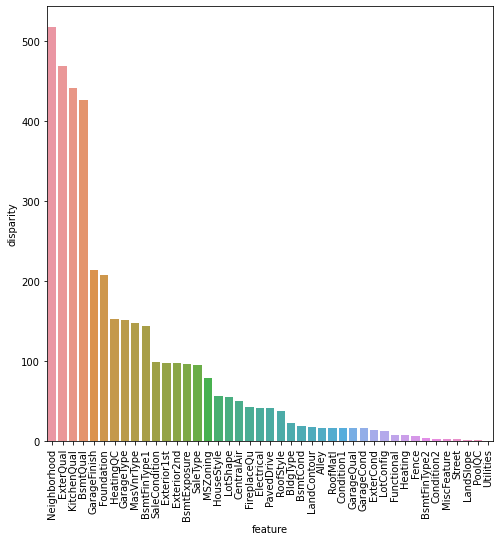

In [6]:
# ANOVA test to see the significance of categorical features
# Inspired by: https://www.kaggle.com/dgawlik/house-prices-eda
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = categorical_features
    pvals = []
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique(): # find sale prices associated with each categorical feature
            s = frame[frame[c] == cls]['SalePrice'].values 
            if len(s) != 0: # drop features with null values
                samples.append(s)
        pval = stats.f_oneway(*samples)[1] # use pval to see influence of each feature to SalePrice
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a.dropna(inplace=True) # drop features have null values
a['disparity'] = np.log(1 / a['pval'].values)
plt.figure(figsize=(8,8))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [7]:
# encode the categorical features based on their mean SalePrice
# For each categorical feature: 
#   1. find SalePrice mean for all labels in that categorical feature,
#   2. reorder the labels based on mean SalePrice ascending
#   3. assign different integer values to each label based on their order
#   4. convert the dictionary type and iterate through every label
#   4.1 inside the loop, change every label to its corresponding integer value in train dataset
def encode_categorical_features(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['index'] = range(1, ordering.shape[0]+1)
    ordering = ordering['index'].to_dict()
    
    for label, index in ordering.items():
        frame.loc[frame[feature]==label, feature+'_E'] = index

categorical_features_encoded = []
for feature in categorical_features:
    encode_categorical_features(train, feature)
    categorical_features_encoded.append(feature+'_E')
categorical_features_encoded

# also encode categorical features for combined dataset
for feature in categorical_features:
    encode_categorical_features(all_data, feature)

In [8]:
all_features = numerical_features.tolist() + categorical_features_encoded
# drop original categorical features that are not encoded
train = train.drop(columns=categorical_features)
all_data = all_data.drop(columns=categorical_features)

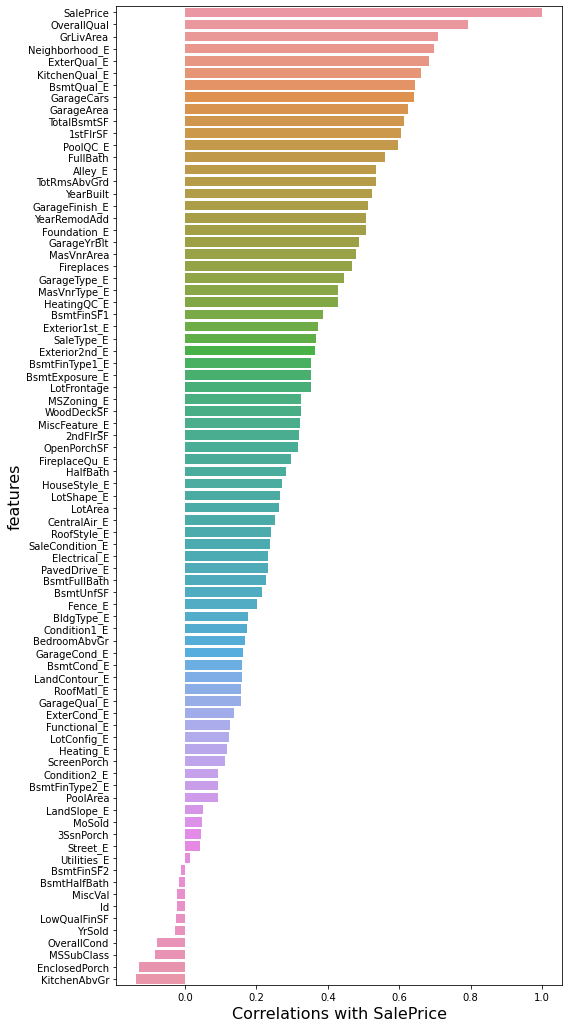

In [9]:
# correlations
corr = train.corr()
corr.sort_values(by=['SalePrice'], ascending=False, inplace=True)

# visualize correlations associate with SalePrice
plt.figure(figsize=(8,18))
ax = sns.barplot(data=corr[['SalePrice']], x='SalePrice', y=corr.index, orient='h')
ax.set_xlabel('Correlations with SalePrice', fontsize=16)
ax.set_ylabel('features', fontsize=16);

# Alternative way to plot correlations using pandas.plot()
# ax = corr[['SalePrice']].plot(kind='barh', figsize=(8,24), fontsize=12)
# ax.set_xlabel('correlations with SalePrice', fontsize=16)
# ax.set_ylabel('features', fontsize=16);

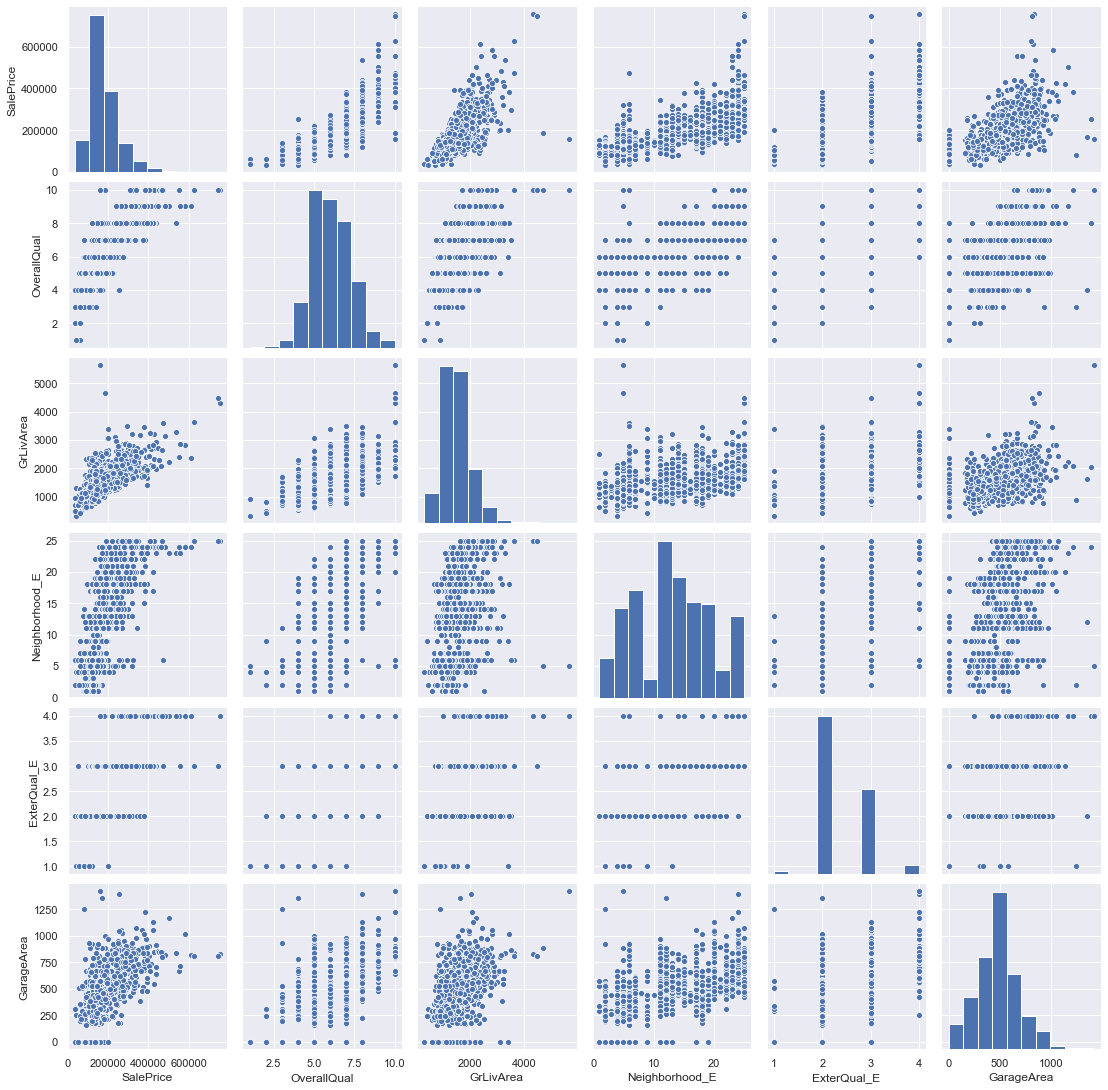

In [10]:
# use seaborn.pairplot() to see the relations between SalePrice and some most important features
columns = ['SalePrice', 'OverallQual', 'GrLivArea', 'Neighborhood_E', 'ExterQual_E', 'GarageArea']
sns.set() # set aesthetic parameters in one step
sns.pairplot(train[columns]);

# Data Preparation

In [11]:
# Log transform of the skewed numerical features to reduce the impact of outliers
# Inspired by: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# Generally, a skewness absolute val of > 0.5 is considered moderate skewed
skewness = train[all_features].apply(lambda x: stats.skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(skewness.shape[0], 'skewed numerical features to log transform')
skewed_features = skewness.index
train[skewed_features] = np.log1p(train[skewed_features])

49 skewed numerical features to log transform


In [12]:
# filling all NaN values with its column mean
train = train.fillna(0.)
all_data = all_data.fillna(0.)

# prepare train and test dataset for model trainning
y = train.SalePrice
train = train.drop(columns=['Id', 'SalePrice'])
all_data = all_data.drop(columns=['Id', 'SalePrice'])
all_features.remove('SalePrice')
all_features.remove('Id')
numerical_features = numerical_features.drop(['Id', 'SalePrice'])

# split the training set
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=0)

print('all_data shape: ', all_data.shape)
print('train shape:    ', train.shape)
print('X_train shape:  ', X_train.shape)
print('X_test shape:   ', X_test.shape)
print('y_train shape:  ', y_train.shape)
print('y_test shape:   ', y_test.shape)

all_data shape:  (2919, 79)
train shape:     (1460, 79)
X_train shape:   (1022, 79)
X_test shape:    (438, 79)
y_train shape:   (1022,)
y_test shape:    (438,)


In [13]:
# error measurement: RMSE
# scorer = make_scorer(mean_squared_error, greater_is_better=False)
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
    return (rmse)

def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=10))
    return (rmse)

# Train the Linear Models

Linear Regression RMSE on training set:  0.19463024050498623
Linear Regression RMSE on test set:      0.13201453357234477


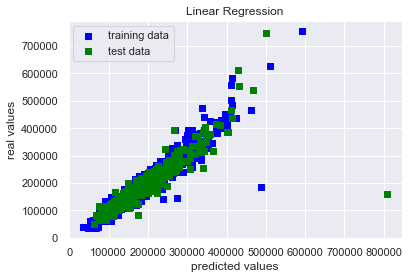

In [14]:
# Standard linear regression without regularization 
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

print('Linear Regression RMSE on training set: ', rmse_cv_train(lr).mean())
print('Linear Regression RMSE on test set:     ', rmse_cv_test(lr).mean())
y_train_predict = np.exp(lr.predict(X_train))
y_test_predict = np.exp(lr.predict(X_test))

# plot predictions vs real values
plt.scatter(y_train_predict, np.exp(y_train), c='blue', marker='s', label='training data')
plt.scatter(y_test_predict, np.exp(y_test), c='green', marker='s', label='test data')
plt.title('Linear Regression')
plt.xlabel('predicted values')
plt.ylabel('real values')
plt.legend(loc='upper left')

In [15]:
# Lasso linear regression (L1 penalty)
lasso = linear_model.LassoCV(max_iter=10000)
lasso.fit(X_train, y_train)

print('Lasso RMSE on trainning set: ', rmse_cv_train(lasso).mean())
print('Lasso RMSE on test set:      ', rmse_cv_test(lasso).mean())

Lasso RMSE on trainning set:  0.19106883045535453
Lasso RMSE on test set:       0.1841082740351277


In [16]:
# Ridge linear regression (L2 penalty)
ridge = linear_model.RidgeCV()
ridge.fit(X_train, y_train)

print('Ridge RMSE on training set: ', rmse_cv_train(ridge).mean())
print('Ridge RMSE on test set:     ', rmse_cv_test(ridge).mean())

Ridge RMSE on training set:  0.1264993946452853
Ridge RMSE on test set:      0.13535507420371728


In [17]:
# ElasticNet linear regression (L1 and L2 penalty)
elasticNet = linear_model.ElasticNetCV()
elasticNet.fit(X_train, y_train)

print('ElasticNet RMSE on training set: ', rmse_cv_train(elasticNet).mean())
print('ElasticNet RMSE on test set:     ', rmse_cv_test(elasticNet).mean())

ElasticNet RMSE on training set:  0.19209338073961083
ElasticNet RMSE on test set:      0.18528287323525056


# Summary

```
In data visualization:
    1. dealing with categorical features and missing values
        1.1. be able to see the categorical features impact on SalePrice using ANOVA
        1.2. and encoded categorical features
    2. correlations of all features with SalePrice
        2.1. be able to see top five most influence features' relationship with SalePrice
In data preparation:
    1. numerical_features combined with categorical_features_encoded to create a new variable: all_features
    2. drop 'Id' and 'SalePrice' features and their values from train data set.
    3. perform normal distribution for all skewed features
    4. split train data set into X_train, y_train, X_test, y_test
    5. define RMSE functions
In model training:
    1. trained Linear Regression, LassoCV, RidgeCV, and ElasticNetCV models

Overall, the training models didn't give ideal results, which I think was the problems in data preparation. I tried sklearn.preprocessing.StandardScaler, it made even worse results. So, learn how to correctly prepare data is important.
    
```